In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import geopandas as gpd
import pandas as pd
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import matplotlib.patches as mpatches

from shapely.geometry import mapping

from rasterio.plot import show
from rasterio.mask import mask
from tqdm import tqdm_notebook as tqdm

import os

%matplotlib inline

In [2]:
base = Path("../processing").joinpath("preprocessing-clipped")
stacked = Path("../processing").joinpath("stacked").joinpath("stacked.tif")
classification = Path("../processing").joinpath("classification")

In [3]:
images = [
    "clip_RT_T31TDH_20170413T104021_B02.tif",
    "clip_RT_T31TDH_20170413T104021_B03.tif",
    "clip_RT_T31TDH_20170413T104021_B04.tif",
    "clip_RT_T31TDH_20170413T104021_B05.tif",
    "clip_RT_T31TDH_20170413T104021_B06.tif",
    "clip_RT_T31TDH_20170413T104021_B07.tif",
    "clip_RT_T31TDH_20170413T104021_B08.tif",
    "clip_RT_T31TDH_20170413T104021_B8A.tif",
    "clip_RT_T31TDH_20170413T104021_B11.tif",
    "clip_RT_T31TDH_20170413T104021_B12.tif",
]

image_rgb = []

with rio.open(base.joinpath(images[0])) as src:
    meta = src.meta
    
meta.update(dtype=rio.uint8)
meta.update(count=len(images))

with rio.open(stacked, 'w', **meta) as dst:
    for identifier, layer in enumerate(images, start=1):        
        with rio.open(base.joinpath(layer)) as src:
            data = src.read(1)
            data = (data * 255).round().astype(rio.uint8)
            dst.write_band(identifier, data)

In [4]:
full_ds = rio.open(stacked)

image_rows, image_cols = full_ds.shape
image_bands = full_ds.count

full_ds.shape, full_ds.count

((2546, 1818), 10)

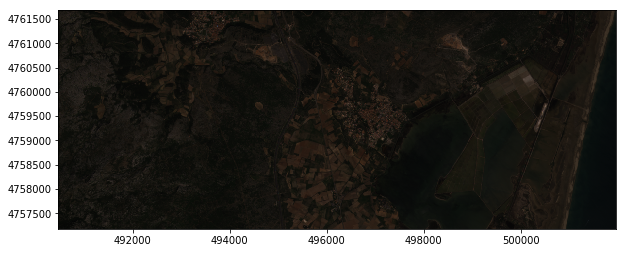

In [5]:
clipped_full_ds = full_ds.read([3,2,1])[:, 150:600, 250:1400]
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_full_ds[:, :, :], ax=ax, transform=full_ds.transform)

In [6]:
gt = gpd.read_file(classification.joinpath("classified_v1.shp"))

In [7]:
geometries = gt.geometry.values

geometry = geometries[0]
print(type(geometry))
print(geometry)

feature = [mapping(geometry)]
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((491830 4761680, 491840 4761680, 491840 4761670, 491830 4761670, 491830 4761680))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((491830.0, 4761680.0), (491840.0, 4761680.0), (491840.0, 4761670.0), (491830.0, 4761670.0), (491830.0, 4761680.0)),)}]


In [8]:
out_image, out_transform = mask(full_ds, feature, crop=True)
out_image.shape

(10, 1, 1)

In [9]:
full_ds.close()

In [10]:
def tqdm_enumerate(iter):
    i = 0
    for y in tqdm(iter):
        yield i, y
        i += 1

In [11]:
X = np.array([], dtype=np.uint8).reshape(0, 10)
y = np.array([], dtype=np.uint8)

checkpoint = Path("../processing").joinpath("checkpoint")
train_X = checkpoint.joinpath("train_X.npy")
train_y = checkpoint.joinpath("train_y.npy")

if not train_X.is_file() and not train_y.is_file():
    print("Building training input")
    with rio.open(stacked) as src:
        band_count = src.count
        for index, geom in tqdm_enumerate(geometries):
            feature = [mapping(geom)]

            out_image, out_transform = mask(src, feature, crop=True)
            out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]
            out_image_trimmed = out_image_trimmed[:, ~np.all(out_image_trimmed == 255, axis=0)]
            out_image_reshaped = out_image_trimmed.reshape((-1, band_count))

            y = np.append(y, [gt["C_ID"][index]] * out_image_reshaped.shape[0])
            X = np.vstack((X, out_image_reshaped))
        np.save(train_X, X)
        np.save(train_y, y)
else:
    print("Rebuilding training input from checkpoint")
    X = np.load(train_X)
    y = np.load(train_y)

Rebuilding training input from checkpoint


In [12]:
LULC = {
    0: 'Unclassified',
    1: 'Lake',
    3: 'Large buildings',
    2: 'Small buildings',
    4: 'Forest',
    5: 'Crops'
}

def map_id_to_lulc(id):
    return LULC[id]

gt['class'] = [map_id_to_lulc(x) for x in gt["C_ID"]]

labels = np.unique(gt["class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 5 classes: ['Crops' 'Forest' 'Lake' 'Large buildings' 'Small buildings']

Our X matrix is sized: (4628628, 10)
Our y array is sized: (4628628,)


In [13]:
X_subset = X[:200_000, :]
y_subset = y[:200_000]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_subset, y_subset,
                                                                    test_size=0.25,
                                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150000, 10), (50000, 10), (150000,), (50000,))

Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

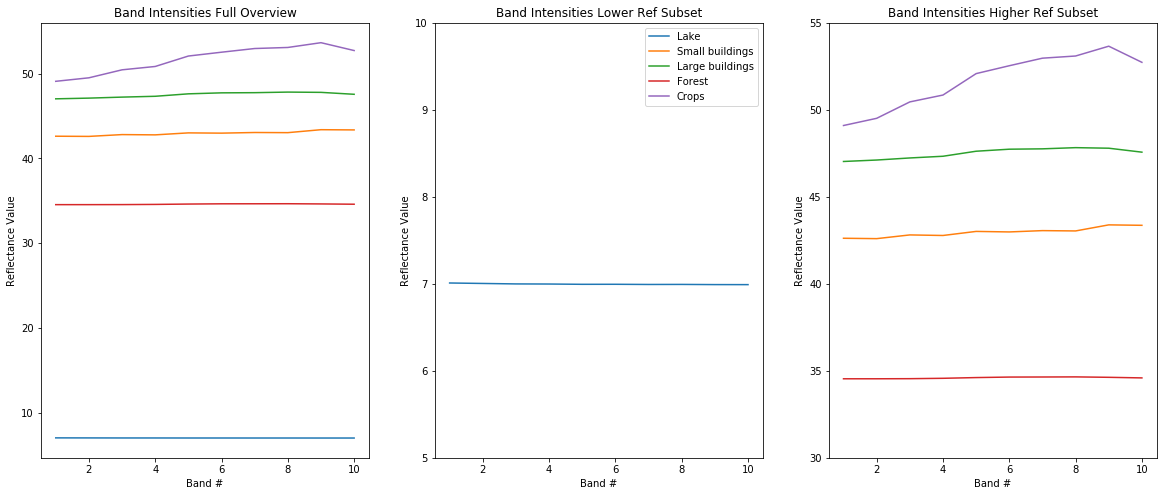

In [14]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1, 11)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=map_id_to_lulc(class_type))
    ax[1].plot(band_count, band_intensity, label=map_id_to_lulc(class_type))
    ax[2].plot(band_count, band_intensity, label=map_id_to_lulc(class_type))
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(5,10)
ax[2].set_ylim(30,55)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

# Random forest experiments

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [48]:
%%time
n_estimators = [100, 200, 300, 400, 500]

scores = []
for estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimators, 
                            random_state=42, 
                            oob_score=True, 
                            n_jobs=6,
                            verbose=True)
    rf.fit(X_subset, y_subset)
    scores.append(rf.oob_score_ * 100)
    print(f"{rf.oob_score_}")
    del rf

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   35.3s finished


0.63887


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   38.6s
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:   39.9s finished


0.6424


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   23.6s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:   36.5s finished


0.643405


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   22.6s
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:  1.0min finished


0.64323


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   23.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  2.1min finished


0.643525
CPU times: user 18min 8s, sys: 13.7 s, total: 18min 22s
Wall time: 14min 24s


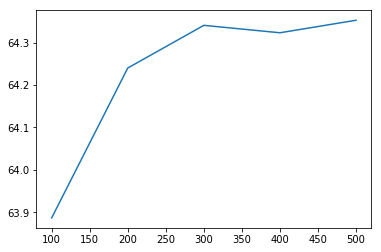

In [49]:
plt.plot(n_estimators, scores)

In [16]:
%%time

rf = RandomForestClassifier(n_estimators=500, 
                            random_state=42, 
                            oob_score=True, 
                            n_jobs=6,
                            verbose=True)

rf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   20.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   44.9s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:   51.0s finished


CPU times: user 5min 40s, sys: 1.48 s, total: 5min 41s
Wall time: 1min 5s


In [33]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 63.99%


In [34]:
pred_test = rf.predict(X_test)
class_labels = np.unique(pred_test)
class_names = [x for x in LULC.items()]

accuracy = metrics.accuracy_score(y_test, pred_test)
f1_scores = metrics.f1_score(y_test, pred_test, average=None)
recall = metrics.recall_score(y_test, pred_test, average=None)
precision = metrics.precision_score(y_test, pred_test, average=None)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    4.4s finished


In [35]:
print(f"Accuracy: {accuracy}")

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}  |  {2:2.1f}  | {3:2.1f}'
          .format(lulctype[1],
                  f1_scores[idx] * 100,
                  recall[idx] * 100,
                  precision[idx] * 100,
                  accuracy * 100))

Accuracy: 0.63872
             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Lake                 = 0.0  |  0.0  | 0.0
         * Large buildings      = 40.2  |  32.4  | 52.7
         * Small buildings      = 76.3  |  89.5  | 66.5
         * Forest               = 44.4  |  32.6  | 69.2
         * Crops                = 33.6  |  25.9  | 47.6


In [37]:
for b, imp in zip(images, rf.feature_importances_):
    print(f"{b} importance: {imp * 100}")

clip_RT_T31TDH_20170413T104021_B02.tif importance: 11.577289493621766
clip_RT_T31TDH_20170413T104021_B03.tif importance: 9.970469064520543
clip_RT_T31TDH_20170413T104021_B04.tif importance: 9.379464231689044
clip_RT_T31TDH_20170413T104021_B05.tif importance: 9.374790920069174
clip_RT_T31TDH_20170413T104021_B06.tif importance: 9.879721816640966
clip_RT_T31TDH_20170413T104021_B07.tif importance: 9.861307465406457
clip_RT_T31TDH_20170413T104021_B08.tif importance: 9.7207041758904
clip_RT_T31TDH_20170413T104021_B8A.tif importance: 9.420392282744354
clip_RT_T31TDH_20170413T104021_B11.tif importance: 9.8668410995797
clip_RT_T31TDH_20170413T104021_B12.tif importance: 10.949019449837612


In [38]:
def apply_mapping_over_array(arr):
    new_arr = []
    for a in arr:
        new_arr.append(LULC[a])
    return np.array(new_arr)
apply_mapping_over_array(y_subset)

array(['Large buildings', 'Large buildings', 'Large buildings', ...,
       'Small buildings', 'Small buildings', 'Small buildings'],
      dtype='<U15')

In [39]:
df = pd.DataFrame()
df['truth'] = apply_mapping_over_array(y_test)
df['predict'] = apply_mapping_over_array(rf.predict(X_test))

pd.crosstab(df['truth'], df['predict'], margins=True)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    4.4s finished


predict          Crops  Forest  Lake  Large buildings  Small buildings    All
truth                                                                        
Crops             2148      60     0             5387              684   8279
Forest             372    2175     7             3890              219   6663
Lake                 0      34     0               24                0     58
Large buildings   1284     733     5            25509              982  28513
Small buildings    706     143     2             3532             2104   6487
All               4510    3145    14            38342             3989  50000

In [17]:
from rasterio.plot import reshape_as_raster, reshape_as_image

with rio.open(stacked) as src:
    stack_profile = src.profile
    img = src.read()
    
print(img.shape)
reshaped_img = reshape_as_image(img)
reshaped_img.shape

(10, 2546, 1818)


(2546, 1818, 10)

In [18]:
%%time

class_prediction = rf.predict(reshaped_img.reshape((-1, 10)))
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   44.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  1.9min finished


CPU times: user 9min 59s, sys: 3min 43s, total: 13min 43s
Wall time: 1min 57s


(-0.5, 1817.5, 2545.5, -0.5)

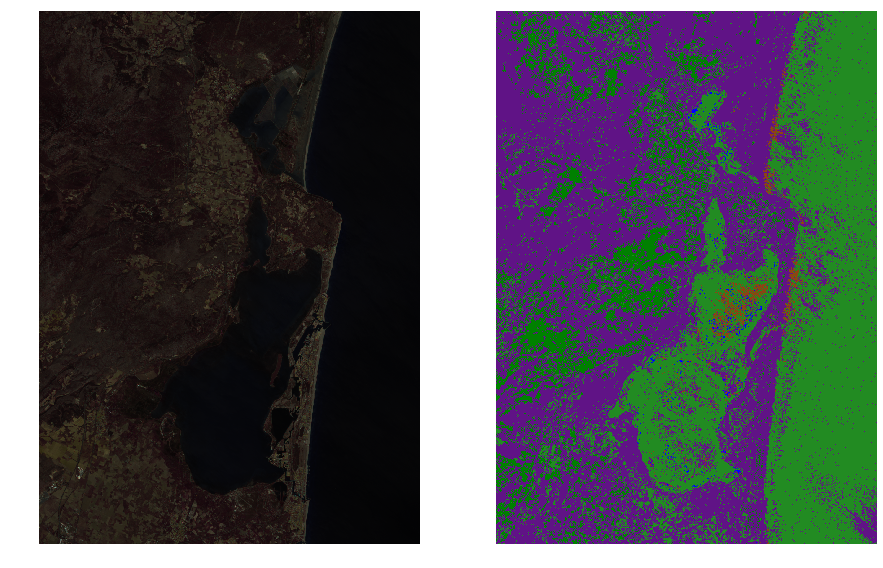

In [19]:
colors = dict({
    (0, (0,0,0,255)), # Unclassified
    (1, (0,0,255,255)), # Water
    (2, (139, 69, 19, 255)), # Small buildings
    (3, (96, 19, 134, 255)), # Large buildings
    (4, (34, 139, 34, 255)), # Forest
    (5, (0, 128, 0, 255)) # Vegetation
})

n = int(np.max(class_prediction))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) 
#            for i in range(len(values)) ]

labels = dict({
    (0, "Unclassified"),
    (1, "Water"),
    (2, "Small buildings"),
    (3, "Large buildings"),
    (4, "Forest"),
    (5, "Vegetation")
})

patches = [ mpatches.Patch(color=v, label=labels[k]) for k, v in colors.items()]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(reshaped_img[:,:,[3,2,1]])
axs[0].axis('off')
axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')
# axs[1].legend(handles=patches)
axs[1].axis('off')

(-0.5, 1817.5, 2545.5, -0.5)

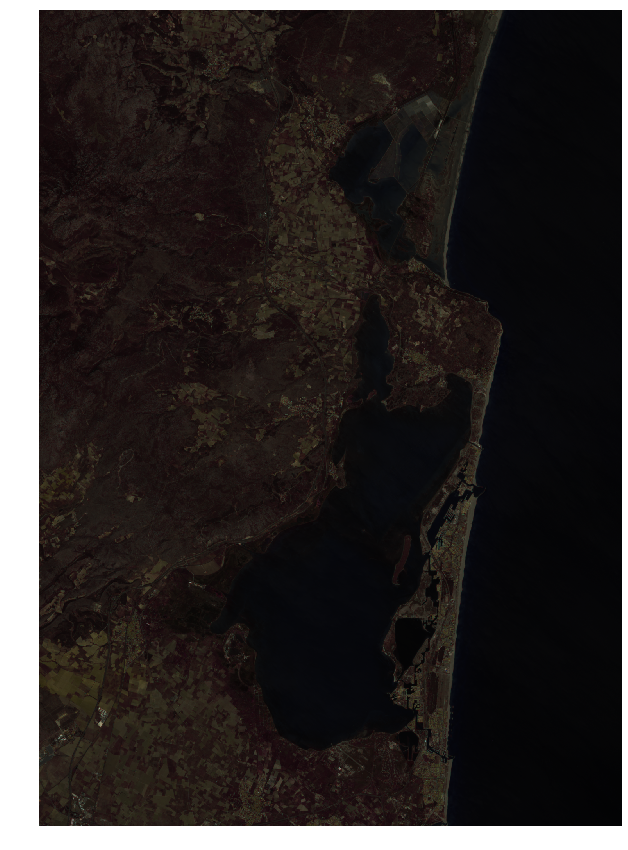

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(reshaped_img[:,:,[3,2,1]])
plt.axis('off')

(-0.5, 1817.5, 2545.5, -0.5)

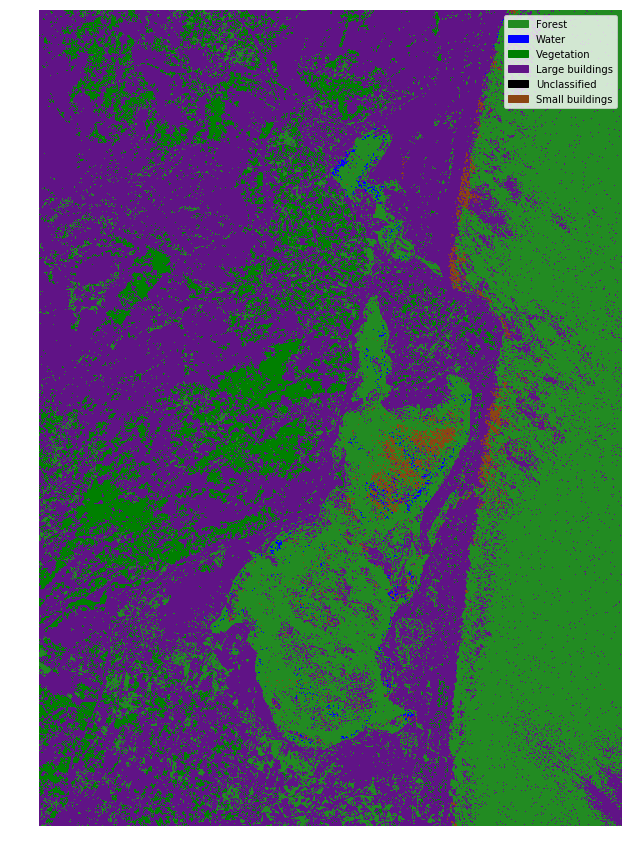

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.legend(handles=patches)
plt.axis('off')

In [65]:
colors

{4: [0.13333333333333333, 0.5450980392156862, 0.13333333333333333, 1.0],
 1: [0.0, 0.0, 1.0, 1.0],
 5: [0.0, 0.5019607843137255, 0.0, 1.0],
 3: [0.3764705882352941, 0.07450980392156863, 0.5254901960784314, 1.0],
 0: [0.0, 0.0, 0.0, 1.0],
 2: [0.5450980392156862, 0.27058823529411763, 0.07450980392156863, 1.0]}

(2, 3, 5)


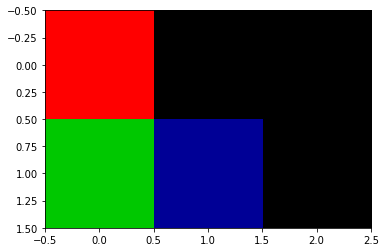

In [34]:
img = np.array([
    [[255,0,0,255,255], [0,0,0,0,0], [0,0,0,0,0]],
    [[0,200,0,0,0], [0,0,150,0,0], [0,0,0,0,0]],
])

print(img.shape)
plt.imshow(  img[:,:,:3]  )